In [ ]:
pip install azure-ai-inference azure-core


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.9/124.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.1/207.1 kB 9.3 MB/s eta 0:00:00


In [4]:
!pip install azure-ai-inference


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.9/124.9 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.1/207.1 kB 15.9 MB/s eta 0:00:00


AUTO DESCRIPTION

In [143]:
import os
import io
import base64
import mimetypes
from PIL import Image
from azure.ai.inference import ChatCompletionsClient
from azure.ai.inference.models import (
    SystemMessage,
    UserMessage,
    TextContentItem,
    ImageContentItem,
    ImageUrl,
)
from azure.core.credentials import AzureKeyCredential

# Convert and compress only if image is larger than 1MB
def image_path_to_data_url(image_path, target_size_kb=1000):
    mime_type, _ = mimetypes.guess_type(image_path)
    img = Image.open(image_path)

    # Convert original to buffer first
    original_buffer = io.BytesIO()
    img.save(original_buffer, format="png")
    original_size_kb = original_buffer.tell() / 1024

    if original_size_kb <= target_size_kb:
        base64_data = base64.b64encode(original_buffer.getvalue()).decode()
        return f"data:{mime_type};base64,{base64_data}"

    # Compress if needed
    quality = 95
    while quality > 10:
        buffer = io.BytesIO()
        img.save(buffer, format="png", quality=quality)
        size_kb = buffer.tell() / 1024
        if size_kb <= target_size_kb:
            break
        quality -= 5

    base64_data = base64.b64encode(buffer.getvalue()).decode()
    return f"data:{mime_type};base64,{base64_data}"

# Main function to analyze images and generate a floorplan
def analyze_images_and_generate_floorplan(image_paths, TOKEN,prompt_text=None):
    ENDPOINT = "https://models.github.ai/inference"
    MODEL = "openai/gpt-4.1"


    client = ChatCompletionsClient(
        endpoint=ENDPOINT,
        credential=AzureKeyCredential(TOKEN),
    )

    if prompt_text is None:
        prompt_text = (
            "These are images of various rooms from a house. Identify each room "
            "(e.g., kitchen, living room, bedroom) and describe its features. "
            "Then, infer a possible layout and generate a textual floorplan of the house."
        )

    # Convert paths to image content items
    image_items = [
        ImageContentItem(image_url=ImageUrl(url=image_path_to_data_url(path)))
        for path in image_paths
    ]

    messages = [
        SystemMessage("You are a helpful assistant that can identify rooms from images and generate a basic floorplan."),
        UserMessage(
            content=[
                TextContentItem(text=prompt_text),
                *image_items
            ]
        )
    ]

    response = client.complete(
        messages=messages,
        temperature=0.8,
        top_p=1.0,
        model=MODEL,
        max_tokens=2048
    )

    return response.choices[0].message.content




Prompt Finetuning

In [67]:
import os
from azure.ai.inference import ChatCompletionsClient
from azure.ai.inference.models import SystemMessage, UserMessage
from azure.core.credentials import AzureKeyCredential

# Function to analyze and summarize the room descriptions
def analyze_room_layout(descriptions: str, endpoint: str, model_name: str, token: str):
    # Initialize the Azure client
    client = ChatCompletionsClient(
        endpoint=endpoint,
        credential=AzureKeyCredential(token),
    )

    # Structured prompt for generating the summary
    prompt = f"""
You are an expert architectural assistant.

Your task is to analyze the room descriptions provided and generate a single, clean paragraph summarizing the apartment or house layout.

Follow these rules:
- Mention the number of bedrooms and bathrooms using the BHK format (e.g., 1BHK, 2BHK).
- Mention the bathroom in the first line along with the kitchen ,living room and bedroom.
- Identify and briefly describe each room (e.g., Kitchen, Living Room, Bedroom, Bathroom, etc.).
- Include key features such as furniture, appliances, flooring, lighting, and windows.
- Explain how the rooms are connected (e.g., "The kitchen opens into the living room").
- Use a professional, architectural tone.
- Output should be a single, well-structured paragraph.

Room Descriptions:
{descriptions}

### Examples of output format

Example 1:
This is a 1BHK apartment with an attached bathroom. The entry opens into a well-lit living room that connects directly to a balcony. To the side is a compact L-shaped kitchen with bar seating. The bedroom, accessible via a short hallway off the living room, includes a sliding wardrobe and large window. The en-suite bathroom features a modern shower cabin and vanity. The layout prioritizes light and privacy, with all spaces efficiently interconnected.

Example 2:
This is a 2BHK layout featuring two bedrooms, two bathrooms, a study, and an open kitchen-living concept. The entry leads into the living area, which flows into the kitchen and includes a side room that functions as a compact study. The master bedroom includes an attached bath and walk-in closet, while the second bedroom is located near the common bathroom. The layout is designed for comfort and functionality, ideal for small families or remote workers.

Example 3:
This 2BHK layout features a master bedroom with an en-suite bathroom and walk-in closet, and a guest bedroom with access to a separate guest bathroom. The spacious living room includes a fireplace and bookshelves, and is adjacent to the modern kitchen, which features granite countertops and a breakfast bar. The layout is ideal for those who value space and functionality, with a small home office for remote work or study.

Example 4:
This is a 2BHK apartment with a spacious open living area and adjacent dining area, ideal for entertaining. The kitchen is designed for functionality with an island and high-end appliances. The master bedroom is comfortably furnished with a queen-sized bed and large closet, and the bathrooms are well-equipped with modern fixtures. The layout offers a good balance of open space and privacy, making it suitable for couples or small families.
"""

    # Send the request to the model
    response = client.complete(
        messages=[
            SystemMessage("You are an expert architect."),
            UserMessage(prompt),
        ],
        temperature=1.0,
        top_p=1.0,
        max_tokens=1000,
        model=model_name
    )

    # Return the response message content (summary of the layout)
    return response.choices[0].message.content



Floor PLan

In [74]:
import requests
from PIL import Image
from io import BytesIO
from IPython.display import display

def generate_floor_plan(user_description: str, api_key: str) -> Image:
    # Azure OpenAI DALL·E 3 API Configuration
    api_base_url = "https://gchil-m9nglnci-swedencentral.cognitiveservices.azure.com"
    api_endpoint = "/openai/deployments/dall-e-3/images/generations?api-version=2024-02-01"

    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }

    # Construct prompt from user input
    prompt = f"""Create a detailed architectural floor plan sketch of a house based on the following description: {user_description}. The floor plan should be in black and white, top-down view, using minimalist lines typical of an architectural blueprint.

"""

    # Prepare the request payload
    data = {
        "prompt": prompt,
        "n": 1,
        "size": "1024x1024",
        "response_format": "url"
    }

    # Make the request
    response = requests.post(api_base_url + api_endpoint, headers=headers, json=data)

    # Handle response
    if response.status_code == 200:
        response_data = response.json()
        image_url = response_data['data'][0]['url']

        # Download and display image
        image = Image.open(BytesIO(requests.get(image_url).content))
        display(image)  # This will display the image inline in Jupyter
        return image
    else:
        print("Error:", response.status_code, response.text)
        return None



Final Call

In [144]:

image_paths = [
        "/content/14_1_optimized_1000.png",
        "/content/14_2_optimized_1000.png",
        "/content/15_2_optimized_1000.png",
        "/content/16_1_optimized_1000.png"
]

result = analyze_images_and_generate_floorplan(image_paths,"your_key")
print(result)



Certainly! Here’s an analysis of each room, their features, and a possible textual floor plan based on the images.

---

**Room Identification and Features**

1. **Kitchen**
   - **Features:** Modern design with dark wood cabinets, stainless steel appliances (fridge, stove, microwave, dishwasher), light countertops, subway tile backsplash, kitchen island with outlets, overhead lighting. Entry door visible, suggesting kitchen is near the entrance.
   
2. **Bedroom**
   - **Features:** Large window with greenery view, queen/king bed with headboard, two nightstands with lamps, neutral decor, ceiling fan, carpeted floor. Lots of natural light.
   
3. **Bathroom**
   - **Features:** Bathtub with shower and curtain, toilet, single-sink vanity with countertop, large mirror, towel rack, minimal wall art, neutral tiles and walls, modern fixtures.
   
4. **Living Room**
   - **Features:** Large sliding glass door opening to a patio or balcony, sofa, armchair, coffee table, TV on low console, cei

In [145]:
endpoint = "https://models.github.ai/inference"
model_name = "openai/gpt-4.1-mini"
token = "your_key"
summary = analyze_room_layout(result ,endpoint, model_name, token)
print(summary)

This is a well-appointed 1BHK apartment featuring a single bedroom, one bathroom, a modern kitchen, and an open living room. The entrance opens directly into the kitchen area, which is equipped with dark wood cabinetry, stainless steel appliances, a subway tile backsplash, and a functional island with integrated outlets under overhead lighting. The kitchen flows seamlessly into the living room, which boasts hardwood flooring, neutral walls, a ceiling fan, and large sliding glass doors that provide abundant natural light and access to a patio or balcony. The bedroom, accessible via a short hallway from the living space, includes a carpeted floor, a sizable window offering views of surrounding greenery, a queen or king bed with a headboard, nightstands with lamps, and a ceiling fan, contributing to a neutral and serene ambiance. Adjacent to the bedroom, the bathroom contains a bathtub with shower curtain, a single-sink vanity with countertop and large mirror, a toilet, modern fixtures, a

In [150]:
image = generate_floor_plan(summary, 'your_key')


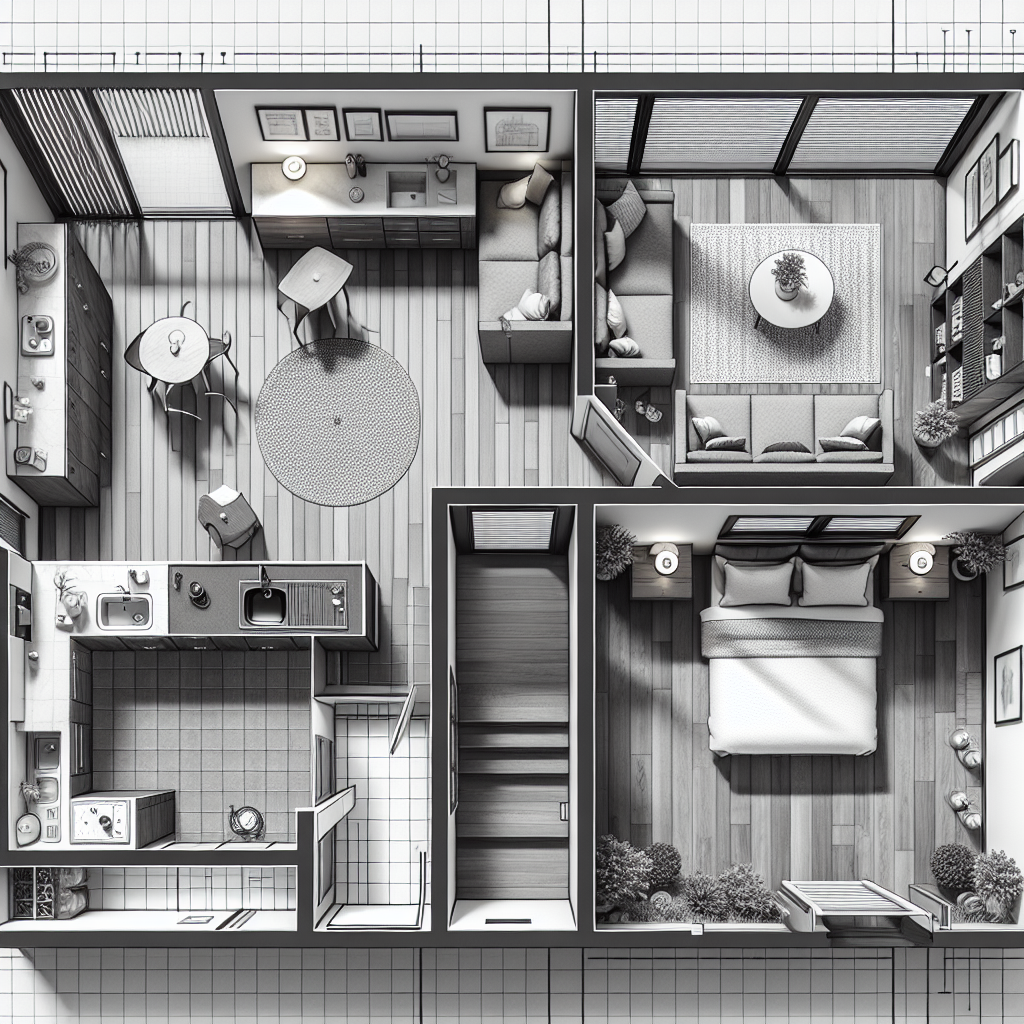

In [151]:
display(image)